# Final Project: Traffic Modeling with the Intelligent Driver Model (IDM)

 $$\textbf{Introduction}$$

For this project, we will be implementing the Intelligent Driver Model (IDM) in order to simulate traffic in one-dimensional space. Before we write any code, we should have a solid understanding of what the IDM is and how we can use it.

The Intelligent Driver Model was developed by Treiber, Hennecke and Helbing in 2000. The IDM is a slight improvement of Gipps' traffic model, and the equation is relatively simple. The IDM equation is probably too complex for us to derive its equation by hand, but python makes quick work of the computation.

Before we introduce the equation, we should go through the problem we are hoping to solve. As this is the first time we are working with any traffic-related problem, we should start with a very (and I mean VERY) simple scenario.

Let's start with two cars that we'll call Car 1 and Car 2. These cars will be driving on a straight road in the same direction, and Car 1 will be in front of Car 2. Car 1 will travel at a constant speed, and we'll use the IDM to determine the velocity and position of Car 2. The IDM has a lot of variables, and we'll need to have real values for each of them.




$$\textbf{The IDM Equation}$$

The IDM equation is the following.

$$\dot{v_\alpha} = \frac{dv_\alpha}{dt} = a = a_{max}(1 - (\frac{v_\alpha}{v_{max}})^\delta - (\frac{s^*(v_\alpha, \Delta v_\alpha)}{s_{\alpha}}))$$

$ s^{*}(v_{\alpha},\Delta v_{\alpha })= s_{0}+v_{\alpha}T+\frac{v_{\alpha }\Delta v_{\alpha}}{2{\sqrt {a_{max}b}}}$

Variables:

$s_{\alpha}$: the distance between two cars

$\Delta v_{\alpha}$: the velocity difference between two cars

$\alpha$: specifies what car we're working with

$v_{max}$ : the "speed limit", the maximum velocity
allowed which the cars will never go over (very realistic!)

$s_{0}$: a minimum desired net distance. Under no circumstances can the distance between two cars be less than $s_{0}$

$T$: the minimum reaction time of driver. So, if the car in fornt suddenly stopped, it would take the driver $T$ seconds to hit their brakes.

$a_{max}$: the maximum vehicle acceleration. Under no circumstances can the car have an acceleration faster than $a_{max}$

$b$: comfortable braking acceleration, a positive number. The acceleration, in this case in the direction opposite to velocity, can be greater than $b$ but the equation will discourage this.

$\delta$: responsible for the "smoothness" of the acceleration



Quite a few of these variables are constants, so for now we'll just give these variables realistic constants. When we finish writing the code, we can potentially change these constants and analyze how our results change.

$\alpha = 2$, which denotes Car 2

$v_{max} = 20 \ m/s$, about 45 mph

$s_{0} = 2 \ m$

$T = 1.5 \ s$

$a_{max} = 2 \ m/s^2$

$b = 0.5 \ m/s^2$

Additionally, we need initial values for $s_{alpha}$, $v_{alpha}$ and $\Delta v_{alpha}$. Our code will solve for these values as it runs, but we need initial values to get the code to run through its first loop. Let's say that Car 1 and Car 2 are 15 meters apart initially, and that Car 2 has an initial velocity of $12 \ m/s$ while Car 1 maintains a speed of $17 \ m/s$.

$s_{\alpha} = 15 \ m$

$v_2 = 12 \ m/s$

$\Delta v_{\alpha} = 17 \ m/s - 12 \ m/s = 5 \ m/s$

$$\textbf{IDM Implementaion and Variable Analysis}$$
Before we dive into the code for the IDM, we should discuss the variable $\delta$ that smoothens the acceleration. Our IDM equation can be broken into two parts, the free road component and the interaction component. $\delta$ is in the free road component, which is $a_{max}(1 - (\frac{v_\alpha}{v_{max}})^\delta)$. Normally, with the IDM, $\delta$ is set to 4 by default. But it's worth it to try to figure out why that is.

We already have constant values for $a_{max}$ and $v_{max}$. So if we then create an arbitrary list of values for $v_{\alpha}$, we can see the effect that different $\delta$ values have. Let's look at $\delta$ values from 1 to 5 and see how it affects the relationship between velocity and acceleration.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
#Variables:
v_max = 20 #m/s^2, about 45 mph
v_car = np.linspace(0, 20, 1000)
Deltas = np.arange(1, 6, 1)
a_max = 2 #m/s^2 maximum acceleartion of vehicle

In [ ]:
a_free_road_1 = []
for i in range (len(v_car)):
    a_new = a_max * (1 - (v_car[i]/v_max) ** Deltas[0])
    a_free_road_1.append(a_new)

a_free_road_2 = []
for i in range (len(v_car)):
    a_new = a_max * (1 - (v_car[i]/v_max) ** Deltas[1])
    a_free_road_2.append(a_new)

a_free_road_3 = []
for i in range (len(v_car)):
    a_new = a_max * (1 - (v_car[i]/v_max) ** Deltas[2])
    a_free_road_3.append(a_new)

a_free_road_4 = []
for i in range (len(v_car)):
    a_new = a_max * (1 - (v_car[i]/v_max) ** Deltas[3])
    a_free_road_4.append(a_new)

a_free_road_5 = []
for i in range (len(v_car)):
    a_new = a_max * (1 - (v_car[i]/v_max) ** Deltas[4])
    a_free_road_5.append(a_new)

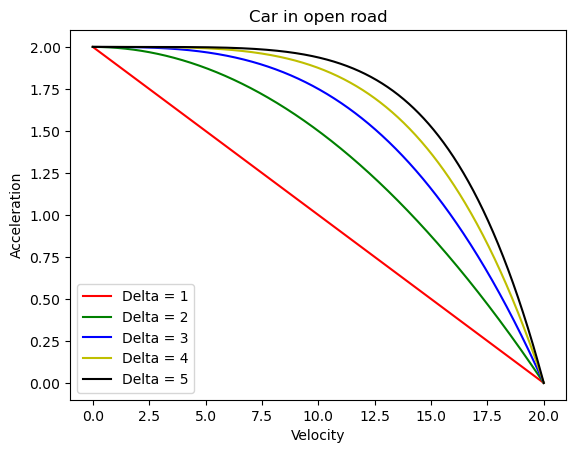

In [ ]:
plt.plot(v_car, a_free_road_1,'r',label='Delta = 1')
plt.plot(v_car, a_free_road_2,'g',label='Delta = 2')
plt.plot(v_car, a_free_road_3,'b',label='Delta = 3')
plt.plot(v_car, a_free_road_4,'y',label='Delta = 4')
plt.plot(v_car, a_free_road_5,'k',label='Delta = 5')
plt.legend(loc='lower left')
plt.xlabel("Velocity")
plt.ylabel('Acceleration')
plt.title('Car in open road')
plt.show()

We can see that the graph is not smooth when $\delta = 1$, as there's no curve in the graph. But the graphs for $\delta =$ 3, 4 and 5 are pretty similar, and our results probably wouldn't differ greatly if we set $\delta$ equal to 3 or 5. For now, let's keep $\delta$ equal to 4 as it is what's normally used.

Now we can get into the heart of the code. The IDM equation solves for acceleration when given velocity, and by using an ODE solver we can get the position and velocity of Car 2. We will be using the Runge-Kutta method to solve the ODE.

The Runge-Kutta method takes weighted averages of the slope of a dataset which are then used to numerically solve the ODE. We are using the rk4 method (rk stands for Runge-Katta) which produces four of these weighted averages. The rk4 method is widely used because it produces accurate results while being computationally efficient.

The challenge for this code will be using the rk4 method while updating the distance between the two cars and the velocity difference between the two cars. We'll need to create separate functions to calculate these two things, and we need to run this code after every loop rk 4 runs through.

First, let's define the rest of the variables we need to define.

In [ ]:
#Rest of variables
s_min = 2 #meters
Delta_norm = 4
v_car_1 = 17 #m/s
v_car_2 = 12 #m/s
v_change_initial = v_car_1 - v_car_2
dist_initial = 15 #meters
T = 1.5 #s
b = 0.5 #m/s^2

Now let's write the functions to calculate distance and $\Delta v$. We will also add a third function s_asterisk that computes $s^{*}(v_{\alpha},\Delta v_{\alpha })$ for us. We could avoid writing this function if we really wanted to, but now we can get the newest value of $s^{*}(v_{\alpha},\Delta v_{\alpha })$ by simply writing s_star[-1] in our code which will be convenient for us later.

In [ ]:
velo = [v_change_initial]
def v_change():
    velo.append(v[-1] - v_car_1)


In [ ]:
s_star = [s_min + (T * v_car_2) + (v_car_2 * velo[-1] / ((2 * a_max * b)**0.5))]
def s_asterisk():
    approx = s_min + (T * v[-1]) + (v[-1] * velo[-1] / ((2 * a_max * b)**0.5))
    s_star.append(approx)

In [ ]:
dist = [dist_initial]
def distance():
    dist.append(dist[-1] + ((v_car_1 - v[-1]) * h) )

Now we can write the code for the rk4 method. Let's have the code run to give us values for 100 seconds, and we'll use a while loop that will run until t = 100. We also need to write an IDM function that puts our velocity and acceleration values in an array. Our acceleration values will be calculated with the IDM equation. Now we can use of rk4 method in the while loop, and we'll call our other functions at the end of the loop so distance and $\Delta v$ are updated.

In [ ]:
def rk4(f,t,h,g):
    k1 = h*g(t,f)
    k2 = h*g(t+0.5*h, f+0.5*k1)
    k3 = h*g(t+0.5*h, f+0.5*k2)
    k4 = h*g(t+h, f+k3)

    return f+ k1/6. + k2/3. + k3/3. + k4/6.

def IDM(t, f):
    x = f[0]
    v = f[1]
    RHS = np.array([v, a_max * ((1 - ((f[1]/ v_max) ** Delta_norm)) - ((s_star[-1] / dist[-1]) ** 2))])
    return RHS

x0 = np.array([0., 12.]) # car 2 starts at x = 0 with an initial velocity of 12 m/s
t0 = 0. # start at t= 0
t_stop = 100
x = [x0[0],]
v = [x0[1],]
t = [t0,]
xold = x0
h=0.01
while t[-1] < t_stop:
    xold = rk4(xold,t[-1],h,IDM)
    x.append(xold[0])
    v.append(xold[1])
    t.append(t[-1]+h)
    s_asterisk()
    v_change()
    distance()

Now we can plot the velocities of the cars. We can also plot the position of Car 2, but the graph for the velocity of Car 2 will be easy to interpret. We can compare the velocity of Car 2 with the velocity of Car 1, which is constant.

Text(0, 0.5, 'Position & Velocity')

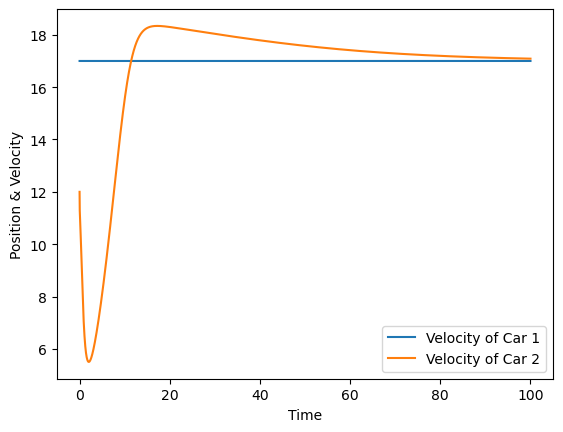

In [ ]:
plt.figure()
#plt.plot(t,x,label='Position of Car 2')
plt.plot(t, [v_car_1] * len(t), label = 'Velocity of Car 1')
plt.plot(t,v, label='Velocity of Car 2')

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel('Velocity (m/s)')

With some analysis, this graph makes a lot of sense. The initial distance between these cars is just 15 meters. And since Car 2 has an initial velocity of 12 meters per second, the driver for Car 2 would have just over a second to react if Car 1 were to abruptly stop. As a result Car 2 slows down, and then speeds up again when it is far apart from Car 1. Car 2, then, essentially matches the velocity of Car 1 for the rest of the trip.  

The graph makes sense given context, but is definitely not perfect. On a road with a 45 mph speed limit, would a real person drive at a speed of 4 m/s (just under 9 mph) to let the other car gain some distance? Probably not. Realistically, a real driver in this situation would slightly lower their speed and then speed up later rather than slowing down and speeding up so quickly.

Let's change some variables and see how our graph changes. First, let's say that Car 1 and Car 2 are 45 meters apart initially rather than 15 meters apart.

In [ ]:
dist_initial = 45 #meters

In [ ]:
dist = [dist_initial]
def distance():
    dist.append(dist[-1] + ((v_car_1 - v[-1]) * h) )

Text(0, 0.5, 'Position & Velocity')

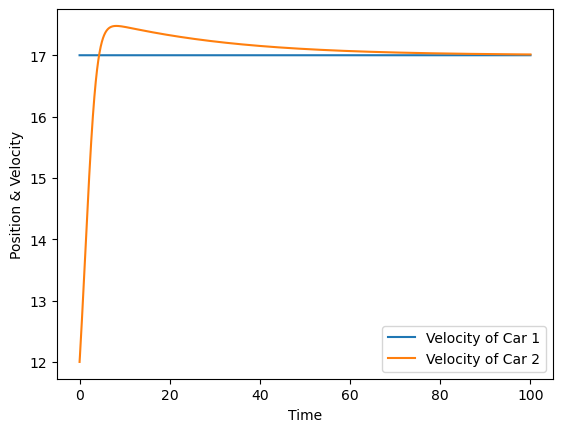

In [ ]:
x0 = np.array([0., 12.]) # car 2 starts at x = 0 with an initial velocity of 12 m/s
t0 = 0. # start at t= 0
t_stop = 100
x = [x0[0],]
v = [x0[1],]
t = [t0,]
xold = x0
h=0.01
while t[-1] < t_stop:
    xold = rk4(xold,t[-1],h,IDM)
    x.append(xold[0])
    v.append(xold[1])
    t.append(t[-1]+h)
    s_asterisk()
    v_change()
    distance()

plt.figure()
plt.plot(t, [v_car_1] * len(t), label = 'Velocity of Car 1')
plt.plot(t,v, label='Velocity of Car 2')
plt.legend()
plt.xlabel("Time")
plt.ylabel('Position & Velocity')



In this case, the cars are far enough apart initially that Car 2 can accelerate up to the speed of Car 1 right at the beginning. The acceleration of Car 2 initially is very high, so perhaps our value for $a_{max}$ is not ideal to simulate realistic traffic. Let's change the initial distance between the cars back to 15 meters and let's reduce $a_{max}$ from $2 \ m/s^2$ to $1 \ m/s^2$.

In [ ]:
a_max = 1 #m/s^2
dist_initial = 15 #m

In [ ]:
dist = [dist_initial]
def distance():
    dist.append(dist[-1] + ((v_car_1 - v[-1]) * h) )

In [ ]:
s_star = [s_min + (T * v_car_2) + (v_car_2 * velo[-1] / ((2 * a_max * b)**0.5))]
def s_asterisk():
    approx = s_min + (T * v[-1]) + (v[-1] * velo[-1] / ((2 * a_max * b)**0.5))
    s_star.append(approx)

In [ ]:
def IDM(t, f):
    x = f[0]
    v = f[1]
    RHS = np.array([v, a_max * ((1 - ((f[1]/ v_max) ** Delta_norm)) - ((s_star[-1] / dist[-1]) ** 2))])
    return RHS

In [ ]:
x0 = np.array([0., 12.]) # car 2 starts at x = 0 with an initial velocity of 12 m/s
t0 = 0. # start at t= 0
t_stop = 100
x = [x0[0],]
v = [x0[1],]
t = [t0,]
xold = x0
h=0.01
while t[-1] < t_stop:
    xold = rk4(xold,t[-1],h,IDM)
    x.append(xold[0])
    v.append(xold[1])
    t.append(t[-1]+h)
    s_asterisk()
    v_change()
    distance()

Text(0, 0.5, 'Position & Velocity')

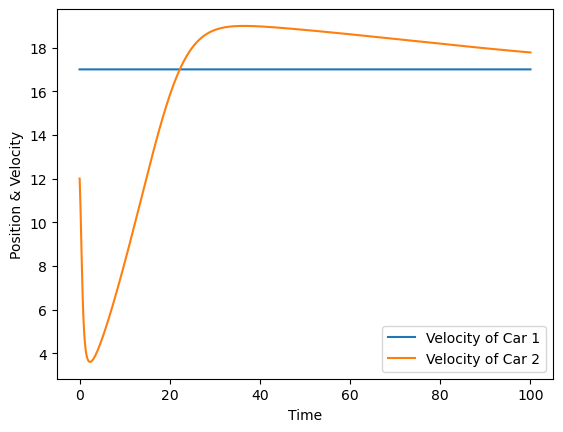

In [ ]:
plt.figure()
plt.plot(t, [v_car_1] * len(t), label = 'Velocity of Car 1')
plt.plot(t,v, label='Velocity of Car 2')
plt.legend()
plt.xlabel("Time")
plt.ylabel('Position & Velocity')

This graph looks pretty similar to our first graph, and just looks like a stretched out version of our first graph. Because our maximum acceleration is more limited, it takes Car 2 a longer time to increase its speed.

We can continue to alter variables, and we could find the "best" set of variables that make things as realistic as possible. But instead, we should probably do something else that will expand our foundational knowledge of traffic modeling.

$$\textbf{Using the IDM with Multiple Cars}$$
Lastly, in this project, we will us the IDM to find the velocity of a third car that is behind Car 2. If we can find the velocity of this third car, then we will have all the tools to add as many cars to the traffic system as we want to.

We will need to use the velocities in Car 2, so we will need to slightly alter our code. We can go through the array of velocities for Car 2. As the code loops, we'll need to transition to the next value in the array. So, it makes sense to remove the values from the list that we've already used and don't need. Before doing this, we should store the list of Car 2 velocities into another variable so we can later graph the velocities of Car 2, as our edited array is no longer accurate.

Let's say that Car 3 has an initial velocity of 7 meters per second and that it is initially 15 meters behind Car 2.

In [ ]:
velocities_car_2 = v[:] #stores the list of velocities for car 2 and ensures it is not altered.

In [ ]:
a_max = 2
v_car_3 = 7 #m/s^2
v_car_change = v_car_2 - v_car_3
dist_initial = 15 #m

In [ ]:
#print(v)
velo = [v_change_initial]
def v_change():
    velo.append(v_3[-1] - v[0])

In [ ]:
s_star = [s_min + (T * v_car_3) + (v_car_3 * velo[-1] / ((2 * a_max * b)**0.5))]
def s_asterisk():
    approx = s_min + (T * v_3[-1]) + (v_3[-1] * velo[-1] / ((2 * a_max * b)**0.5))
    s_star.append(approx)

In [ ]:
dist = [dist_initial]
def distance():
    dist.append(dist[-1] + ((v_3[-1] - v[0]) * h) )


In [ ]:
def rk4(f,t,h,g):
    k1 = h*g(t,f)
    k2 = h*g(t+0.5*h, f+0.5*k1)
    k3 = h*g(t+0.5*h, f+0.5*k2)
    k4 = h*g(t+h, f+k3)

    return f+ k1/6. + k2/3. + k3/3. + k4/6.

def IDM(t, f):
    x = f[0]
    v_3 = f[1]
    RHS = np.array([v_3, a_max * ((1 - ((f[1]/ v_max) ** Delta_norm)) - ((s_star[-1] / dist[-1]) ** 2))])
    return RHS

x0 = np.array([0., 7.]) # car 3 starts at x = 0 with an initial velocity of 7 m/s
t0 = 0. # start at t= 0
t_stop = 100
x = [x0[0],]
v_3 = [x0[1],]
t = [t0,]
xold = x0
h=0.01
while t[-1] < t_stop:
    xold = rk4(xold,t[-1],h,IDM)
    x.append(xold[0])
    v_3.append(xold[1])
    t.append(t[-1]+h)
    s_asterisk()
    v_change()
    distance()
    v.pop(0)

Text(0, 0.5, 'Position & Velocity')

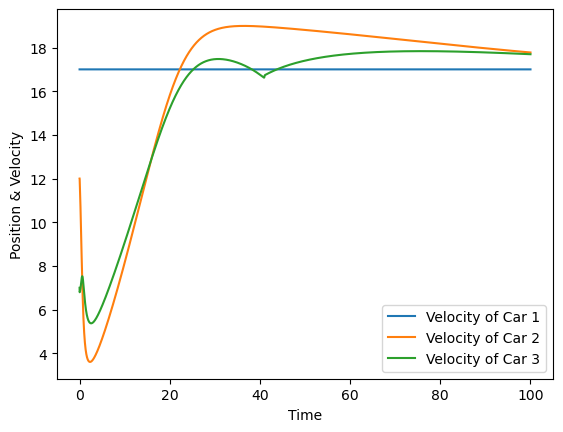

In [ ]:
plt.figure()
plt.plot(t, [v_car_1] * len(t), label = 'Velocity of Car 1')
plt.plot(t, velocities_car_2, label='Velocity of Car 2')
plt.plot(t,v_3, label='Velocity of Car 3')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel('Velocity (m/s)')

We now have a graph of the speed of Car 3, which looks fairly accurate. Even though Car 2 and Car 3 are decently close to one another at the start, Car 3 has a slow initial speed so it is likely that Car 3 will not crash into Car 2. Then, Car 3 and Car 2 accelerate at similar rates and then converge to the same speed at the end of the graph. I'm not quite sure what causes the small dip in velocity for Car 3 when $t = 40\ s$, but nonetheless will still have a basic illustration of a simple traffic system using the IDM.

$$\textbf{Conclusion}$$

We've successfully developed a traffic system by using the Intelligent Driver Model. Although we kept the system simple, the code in this project is the foundation for more complex, realistic traffic systems. In the future, we can expand our model to include more cars, multiple roads, multiple lanes intersections, traffic lights, and many other things. Thanks for a great semester!

$$\textbf{Useful Links}$$
https://towardsdatascience.com/simulating-traffic-flow-in-python-ee1eab4dd20f


https://www.javatpoint.com/traffic-flow-simulation-in-python

https://link.springer.com/book/10.1007/978-3-642-32460-4
